**You must restart the program(ctrl+m+.) in order to import the accurate version of matplotlib.**

In [1]:
import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()
import anndata as ad
import pandas as pd


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.5.7
scanpy version:1.9.6


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [2]:
adata_control1 = sc.read_10x_mtx(
    'data/MPNs/Control/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-MPNs-Control-matrix.h5ad


In [3]:
adata_control2 = sc.read_10x_mtx(
    'data/MPNs/Control2/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... reading from cache file cache/data-MPNs-Control2-matrix.h5ad


In [4]:
adata_case1 = sc.read_10x_mtx(
    'data/MPNs/Case/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                                 # write a cache file for faster subsequent reading

... reading from cache file cache/data-MPNs-Case-matrix.h5ad


In [5]:
adata_case2 = sc.read_10x_mtx(
    'data/MPNs/Case2/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                                 # write a cache file for faster subsequent reading

... reading from cache file cache/data-MPNs-Case2-matrix.h5ad


In [6]:
adata_control1.obs['donor'] = 'Control'
adata_control2.obs['donor'] = 'Control'

adata_case1.obs['donor'] = 'Case'
adata_case2.obs['donor'] = 'Case'

In [7]:
adata = ad.concat([adata_control1, adata_control2, adata_case1, adata_case2])

In [8]:
adata

AnnData object with n_obs × n_vars = 42813 × 36601
    obs: 'donor'

## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation.

But if you want to experience step-by-step preprocessing, we also provide more detailed preprocessing steps here, please refer to our [preprocess chapter](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess/) for a detailed explanation.

We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [9]:
#adata=ov.single.scanpy_lazy(adata)

#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

#Neighbourhood graph construction
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
sc.tl.leiden(adata)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 42813
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 12271 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 44.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.1%
    Scrublet finished (0:00:43)
Cells retained after scrublet: 40898, 1915 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower 

AnnData object with n_obs × n_vars = 1492 × 2000
    obs: 'donor', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'leiden'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [10]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='cellmarker',
                          tissue='All',
)

...Creating directory temp
......Downloading dataset save to temp/pySCSA_2023_v2_plus.db
......[whole Size of file]: 14.09 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！5.802087783813477.2f s


In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.

`rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`, if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`

In [11]:
anno=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:00)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 896
Other Gene number: 4385
Cluster 1 Gene number: 2098
Other Gene number: 4070
Cluster 2 Gene number: 692
Other Gene number: 4241
Cluster 3 Gene number: 273
Other Gene number: 4394
Cluster 4 Gene number: 265
Other Gene number: 4417
Cluster 5 Gene number: 2062
Other Gene number: 4125
Cluster 6 Gene number: 1616
Other Gene number: 3919
Cluster 7 Gene number: 38
Other Gene number: 4431
Cluster 8 Gene number: 538
Other Gene number: 4355
Cluster 9 Gene number: 1565
Other Gene number: 4041
#Cluster Type Celltype Score Times
['0', '?', 'T cell|Natural killer T (NKT) cell', '1

We can query only the better annotated results

In [12]:
scsa.cell_auto_anno(adata,key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


We can also use `panglaodb` as target to annotate the celltype

In [13]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='cancer',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'

)

In [14]:
res=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:00)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 12611
Cluster 0 Gene number: 896
Other Gene number: 1415
Cluster 1 Gene number: 2098
Other Gene number: 1367
Cluster 2 Gene number: 692
Other Gene number: 1330
Cluster 3 Gene number: 273
Other Gene number: 1408
Cluster 4 Gene number: 265
Other Gene number: 1422
Cluster 5 Gene number: 2062
Other Gene number: 1360
Cluster 6 Gene number: 1616
Other Gene number: 1183
Cluster 7 Gene number: 38
Other Gene number: 1426
Cluster 8 Gene number: 538
Other Gene number: 1381
Cluster 9 Gene number: 1565
Other Gene number: 1294
#Cluster Type Celltype Score Times
['0', '?', 'T Memory Cells|T Cells', '3.90462469041

We can query only the better annotated results

In [15]:
scsa.cell_anno_print()

Cluster:0	Cell_type:T Memory Cells|T Cells	Z-score:3.905|3.896
Cluster:1	Cell_type:T Cells|T Memory Cells	Z-score:4.021|4.009
Nice:Cluster:2	Cell_type:Platelets	Z-score:8.168
Nice:Cluster:3	Cell_type:Platelets	Z-score:8.64
Cluster:4	Cell_type:Platelets|Erythroid-like And Erythroid Precursor Cells	Z-score:7.476|4.55
Cluster:5	Cell_type:T Cells|T Memory Cells	Z-score:3.539|3.207
Cluster:6	Cell_type:Monocytes|Macrophages	Z-score:3.712|3.335
Cluster:7	Cell_type:Dendritic Cells|Langerhans Cells	Z-score:3.129|2.407
Cluster:8	Cell_type:NK Cells|Decidual Cells	Z-score:4.608|2.782
Cluster:9	Cell_type:Plasmacytoid Dendritic Cells|Dendritic Cells	Z-score:6.173|3.582


In [16]:
scsa.cell_auto_anno(adata,key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


Here, we introduce the dimensionality reduction visualisation function `ov.utils.embedding`, which is similar to `scanpy.pl.embedding`, except that when we set `frameon='small'`, we scale the axes to the bottom-left corner and scale the colourbar to the bottom-right corner.

- adata: the anndata object
- basis: the visualized embedding stored in adata.obsm
- color: the visualized obs/var
- legend_loc: the location of legend, if you set None, it will be visualized in right.
- frameon: it can be set `small`, False or None
- legend_fontoutline: the outline in the text of legend.
- palette: Different categories of colours, we have a number of different colours preset in omicverse, including `ov.utils.palette()`, `ov.utils.red_color`, `ov.utils.blue_color`, `ov.utils.green_color`, `ov. utils.orange_color`. The preset colours can help you achieve a more beautiful visualisation.

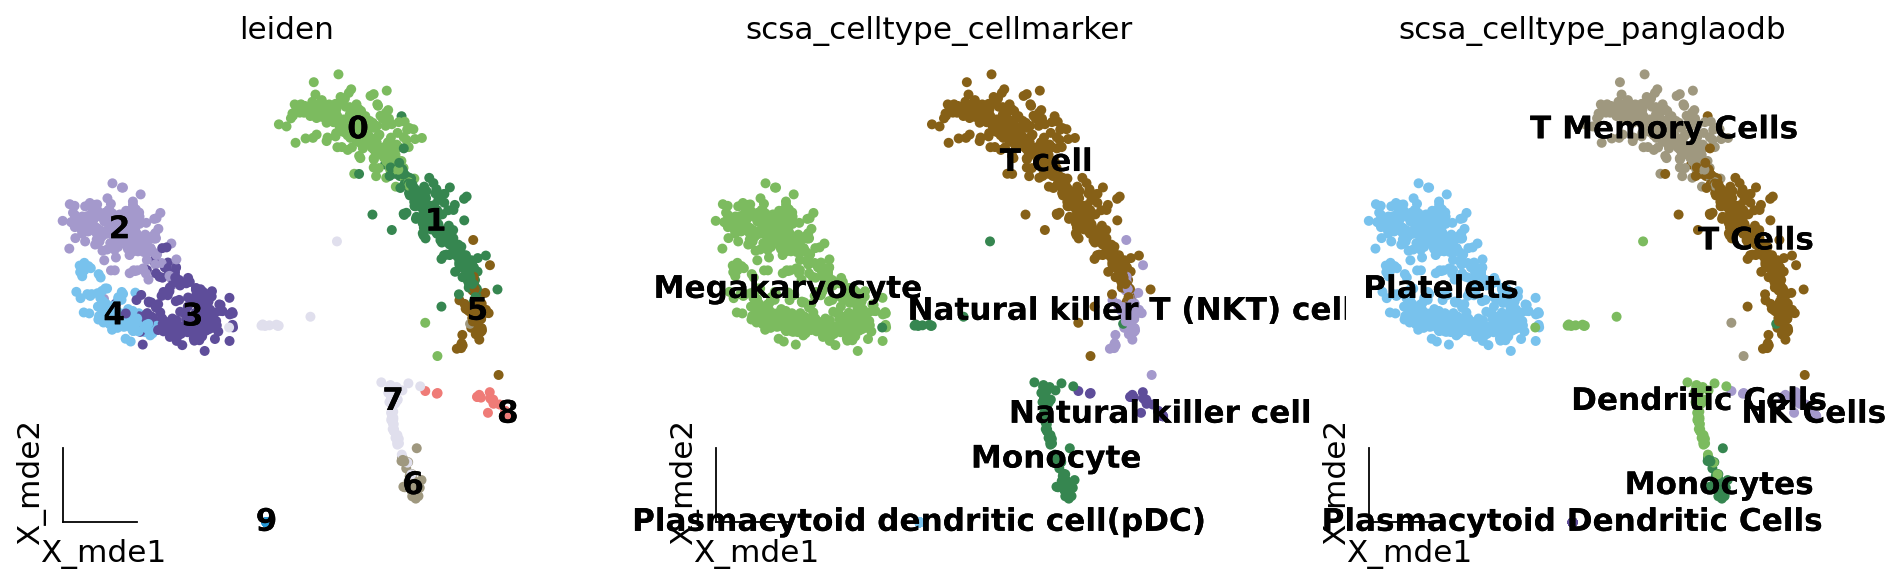

In [17]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['leiden','scsa_celltype_cellmarker','scsa_celltype_panglaodb'],
                   legend_loc='on data',
                   frameon='small',
                   legend_fontoutline=0.01,
                   palette=ov.utils.palette(),
                   save='SCSA_cellType_annotation.png',
                
                  )

If you want to draw stacked histograms of cell type proportions, you first need to colour the groups you intend to draw using `ov.utils.embedding`. Then use `ov.utils.plot_cellproportion` to specify the groups you want to plot, and you can see a plot of cell proportions in the different groups

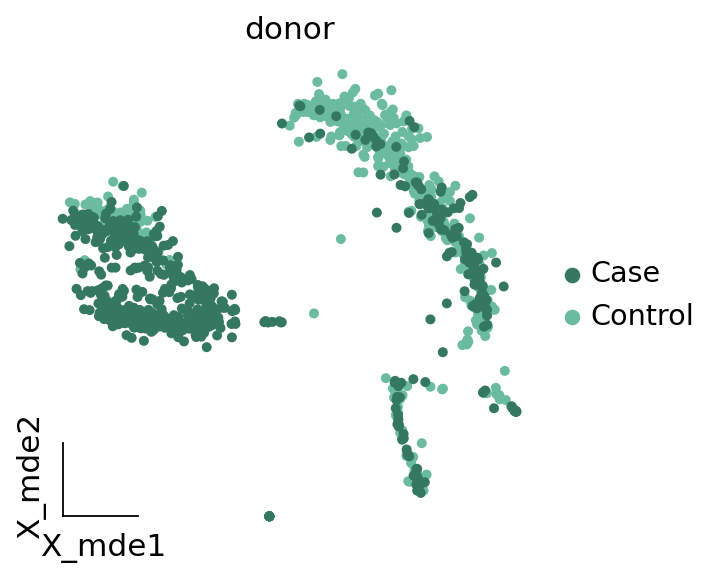

In [18]:
#Randomly designate the first 1000 cells as group B and the rest as group A
# adata.obs['group']='A'
# adata.obs.loc[adata.obs.index[:1000],'group']='B'
#Colored
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['donor'],
                   frameon='small',legend_fontoutline=2,
                   palette=ov.utils.blue_palette(),
                   save='Donor_cells.png',
                  )

(<Figure size 160x320 with 1 Axes>,
 <AxesSubplot: xlabel='Donor', ylabel='Cells per Stage'>)

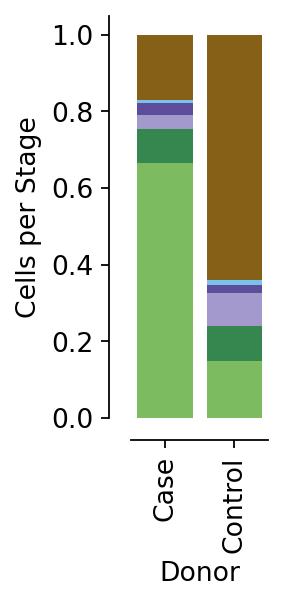

In [19]:
ov.utils.plot_cellproportion(adata=adata,celltype_clusters='scsa_celltype_cellmarker',
                    visual_clusters='donor',
                    visual_name='Donor',figsize=(2,4))

Of course, we also provide another downscaled visualisation of the graph using `ov.utils.plot_embedding_celltype`

(<Figure size 960x800 with 2 Axes>,
 [<AxesSubplot: xlabel='X_mde1', ylabel='X_mde2'>, <AxesSubplot: >])

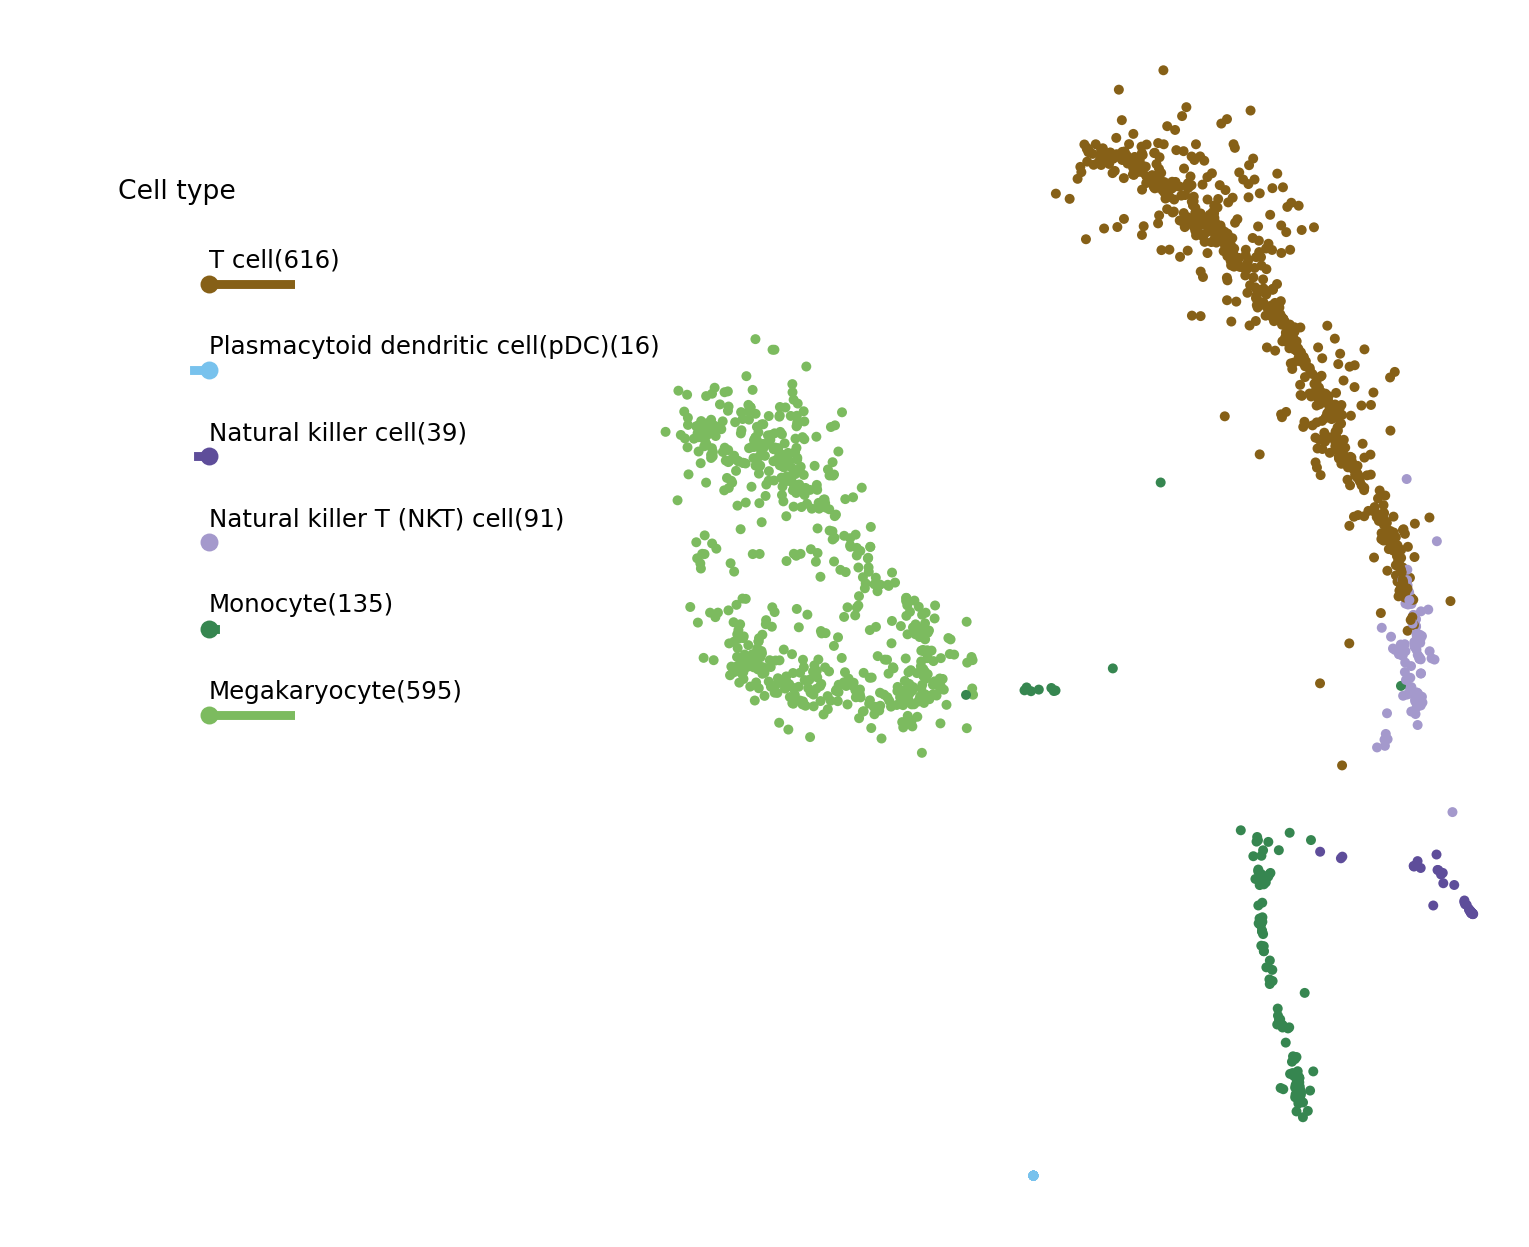

In [20]:
ov.utils.plot_embedding_celltype(adata,figsize=(12, 10),basis='X_mde',
                            celltype_key='scsa_celltype_cellmarker',
                            title='            Cell type',
                            celltype_range=(2,6),
                            embedding_range=(4,10),)

We calculated the ratio of observed to expected cell numbers (Ro/e) for each cluster in different tissues to quantify the tissue preference of each cluster (Guo et al., 2018; Zhang et al., 2018). The expected cell num- bers for each combination of cell clusters and tissues were obtained from the chi-square test. One cluster was identified as being enriched in a specific tissue if Ro/e>1.

The Ro/e function was wrote by `Haihao Zhang`.

In [21]:
roe=ov.utils.roe(adata, sample_key='donor', cell_type_key='scsa_celltype_cellmarker')

chi2: 466.9676345410502, dof: 5, pvalue: 1.0735014049555021e-98


Text(0.5, 1.0, 'Ro/e')

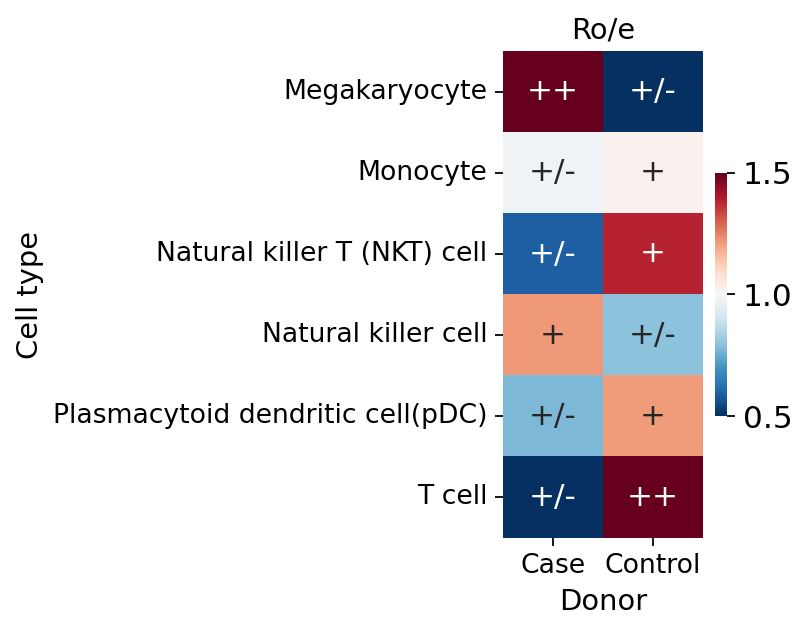

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,4))

transformed_roe = roe.copy()
transformed_roe = transformed_roe.applymap(
    lambda x: '+++' if x >= 2 else ('++' if x >= 1.5 else ('+' if x >= 1 else '+/-')))

sns.heatmap(roe, annot=transformed_roe, cmap='RdBu_r', fmt='',
            cbar=True, ax=ax,vmin=0.5,vmax=1.5,cbar_kws={'shrink':0.5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Donor',fontsize=13)
plt.ylabel('Cell type',fontsize=13)
plt.title('Ro/e',fontsize=13)

## Cell annotate manually

In order to compare the accuracy of our automatic annotations, we will here use marker genes to manually annotate the cluster and compare the accuracy of the pySCSA and manual.

We need to prepare a marker's dict at first

In [24]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],

}

We then calculated the expression of marker genes in each cluster and the fraction

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Megakaryocyte, Dendritic cell, Monocyte, etc.


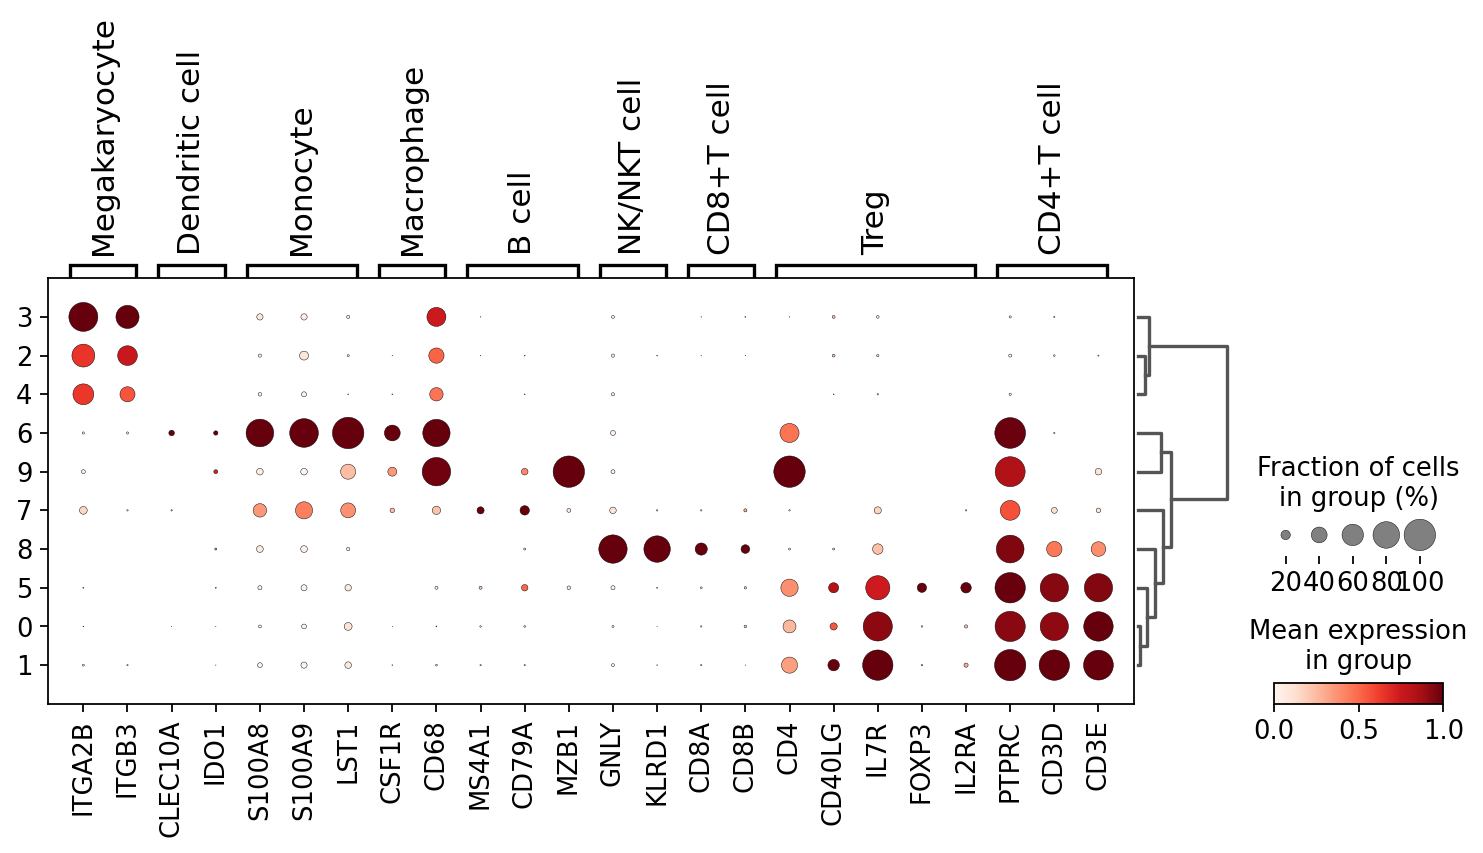

In [25]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden',
              dendrogram=True,standard_scale='var')

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [26]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'T cell',
     '2': 'Monocyte',#Germ-cell(Oid)
     '3': 'B cell',#Germ-cell(Oid)
     '4': 'T cell',
     '5': 'Macrophage',
     '6': 'NKT cells',
     '7': 'T cell',
    '8':'Monocyte',
    '9':'Dendritic cell',
    '10':'Megakaryocyte',

}
ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                       clustertype='leiden')

...cell type added to major_celltype on obs of anndata


## Compare the pySCSA and Manual

We can see that the auto-annotation results are almost identical to the manual annotation, the only difference is between monocyte and macrophages, but in the previous auto-annotation results, pySCSA gives the option of `monocyte|macrophage`, so it can be assumed that pySCSA performs better on the pbmc3k data

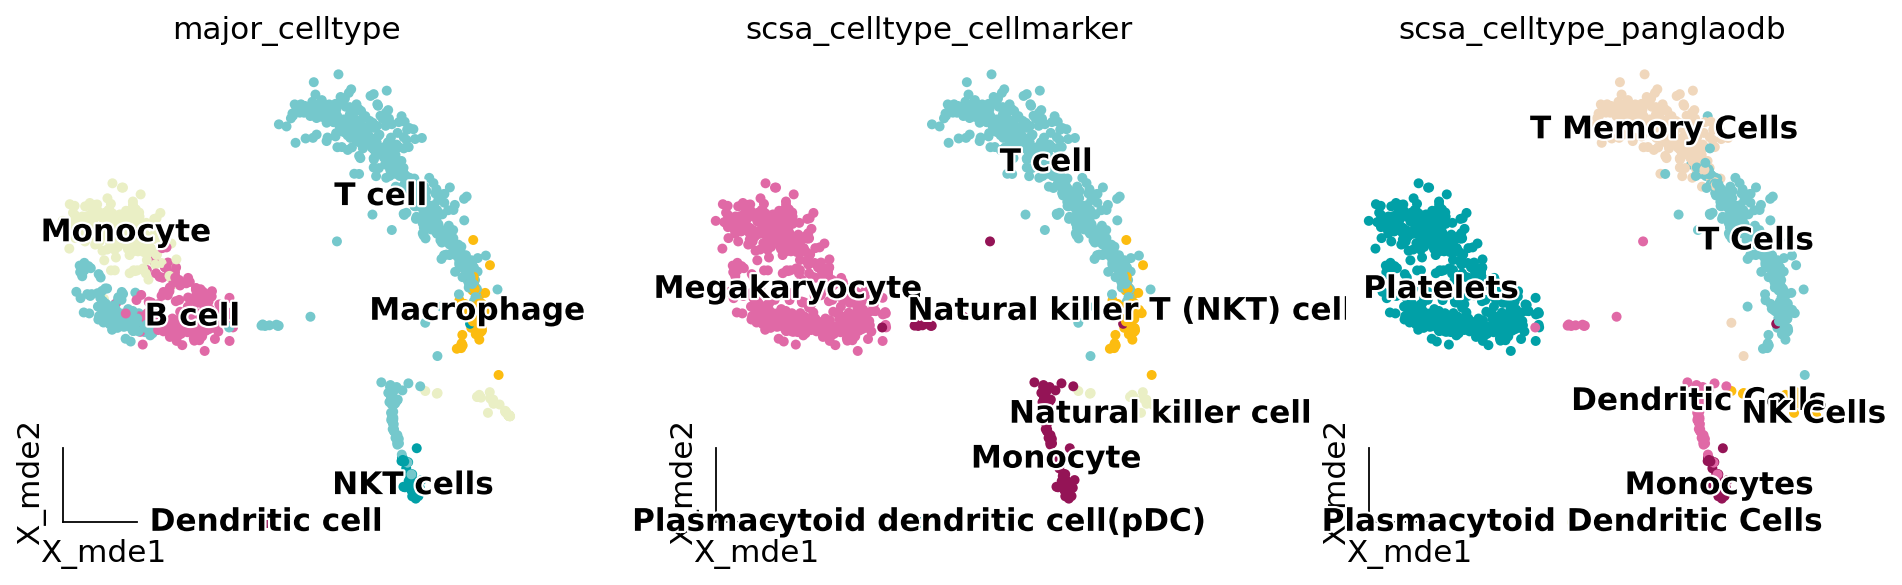

In [27]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['major_celltype','scsa_celltype_cellmarker', 'scsa_celltype_panglaodb'],
                   legend_loc='on data', frameon='small',legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

We can use `get_celltype_marker` to obtain the marker of each celltype

In [28]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype_cellmarker')
marker_dict.keys()

...get cell type marker
ranking genes
    finished (0:00:00)


dict_keys(['Megakaryocyte', 'Monocyte', 'Natural killer T (NKT) cell', 'Natural killer cell', 'Plasmacytoid dendritic cell(pDC)', 'T cell'])

In [29]:
marker_dict['T cell']

array(['RPL30', 'RPL13', 'RPS6', 'RPS3A', 'RPS12', 'RPL32', 'RPL9',
       'RPL21', 'RPS15A', 'RPL3', 'RPS27A', 'RPS14', 'RPL5', 'RPS25',
       'RPS8', 'RPS29', 'RPS27', 'RPS3', 'RPS13', 'RPS16', 'RPL19',
       'RPL11', 'RPL34', 'RPLP2', 'EEF1A1', 'RPS10', 'TPT1', 'RPL14',
       'RPL35A', 'RPS18', 'RPS5', 'RPL10', 'RPL18', 'RPS23', 'RPS2',
       'EEF1B2', 'RPL10A', 'RPS15', 'RPL13A', 'RPL23A', 'RPL37', 'RPL22',
       'RPL36', 'RPL18A', 'RPS4X', 'RPL27A', 'RPL29', 'RPS20', 'RPS21',
       'RPL38', 'RPSA', 'RPS28', 'RPL28', 'RPL39', 'RPL27', 'EEF1G',
       'RPL17', 'RPL12', 'RPL7A', 'RPS7', 'RPL7', 'GAS5', 'RPL24',
       'RPL23', 'NPM1', 'RPS19', 'RPL26', 'BCL11B', 'RPS9', 'RPL41',
       'RPL31', 'TCF7', 'LTB', 'RPL37A', 'RPL35', 'NACA', 'RPL6', 'RACK1',
       'NOP53', 'RPL8', 'RPLP1', 'FAU', 'RPL36A', 'CD3E', 'EEF1D',
       'RPL15', 'RPS11', 'IL7R', 'EIF3E', 'UBA52', 'RPLP0', 'MALAT1',
       'SNHG29', 'TOMM7', 'ZFP36L2', 'RPL4', 'PCED1B-AS1', 'BTG1', 'CD48',
       'CD3D', 'K

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [30]:
scsa.get_model_tissue()

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          

In [31]:
samp_adata = adata.copy()

In [32]:
sc.tl.rank_genes_groups(samp_adata, groupby='donor', method='t-test')

ranking genes
    finished (0:00:00)


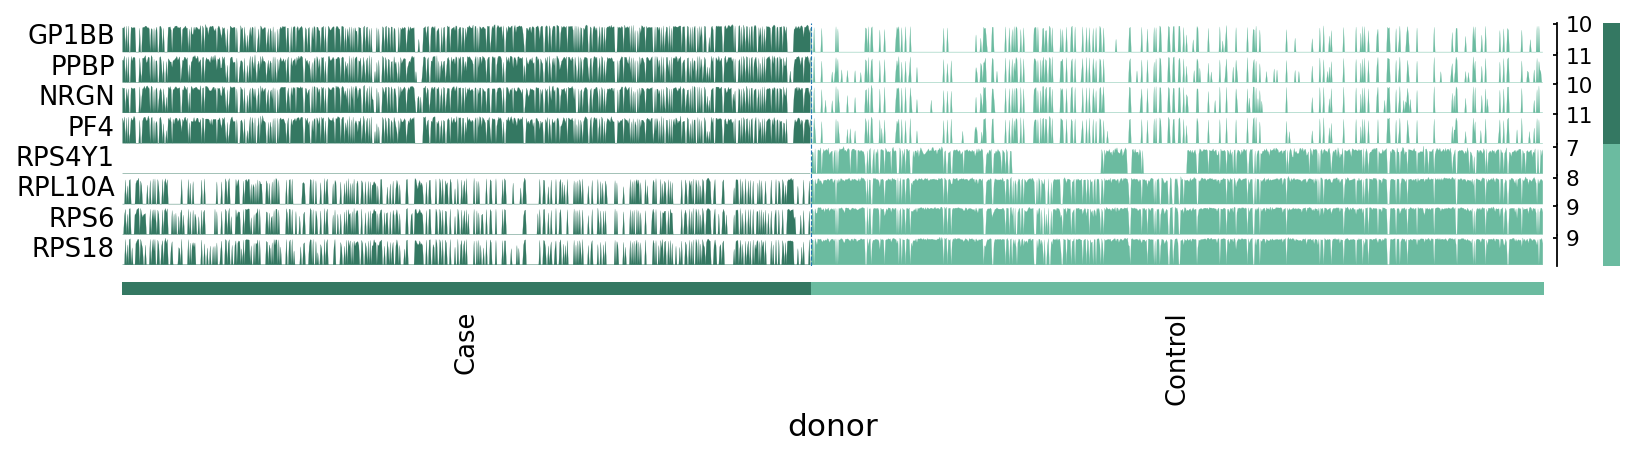

In [33]:
sc.pl.rank_genes_groups_tracksplot(samp_adata, dendrogram=False, n_genes=4, save='rank_genes_group_per_donor.png')

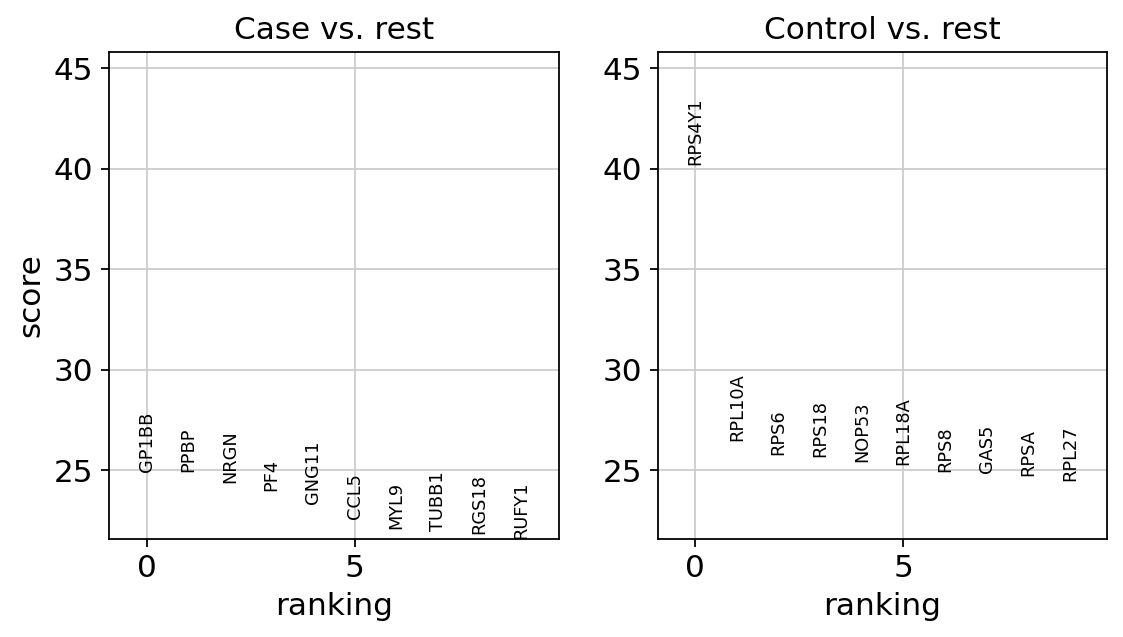

In [34]:
sc.pl.rank_genes_groups(samp_adata, n_genes=10)

In [35]:
donors = samp_adata.uns['rank_genes_groups']['names'].dtype.names

In [36]:
result = samp_adata.uns['rank_genes_groups']

In [37]:
import numpy as np

out = np.array([[0, 0, 0, 0, 0, 0]])

for donor in donors:
    out = np.vstack((out, np.vstack((result['names'][donor],
                                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                                     result['scores'][donor],
                                     result['pvals_adj'][donor],
                                     result['logfoldchanges'][donor],
                                     np.array([donor] * len(result['names'][donor])).astype('object'))).T))

In [38]:
out.shape

(30795, 6)

In [39]:
marker = pd.DataFrame(out[1:], columns=['Gene', 'Method', 'Score', 'pval_adj', 'lfc', 'Donor'])

In [40]:
marker

,Gene,Method,Score,pval_adj,lfc,Donor
0,GP1BB,t-test,24.915697,0.0,7.089696,Case
1,PPBP,t-test,24.903852,0.0,7.498414,Case
2,NRGN,t-test,24.380199,0.0,6.778628,Case
3,PF4,t-test,23.996536,0.0,7.000862,Case
4,GNG11,t-test,23.31139,0.0,6.42914,Case
...,...,...,...,...,...,...
30789,GNG11,t-test,-23.31139,0.0,-6.42914,Control
30790,PF4,t-test,-23.996536,0.0,-7.000862,Control
30791,NRGN,t-test,-24.380199,0.0,-6.778628,Control
30792,PPBP,t-test,-24.903852,0.0,-7.498414,Control


In [41]:
marker[marker.Gene == 'NDUFS1']

,Gene,Method,Score,pval_adj,lfc,Donor
11170,NDUFS1,t-test,-3.096029,0.00595,-0.883683,Case
19623,NDUFS1,t-test,3.096029,0.00595,0.883683,Control


### Significant Gene Filtering

In [42]:
marker[(marker.pval_adj < 0.05) & (abs(marker.lfc) > 1)]

,Gene,Method,Score,pval_adj,lfc,Donor
0,GP1BB,t-test,24.915697,0.0,7.089696,Case
1,PPBP,t-test,24.903852,0.0,7.498414,Case
2,NRGN,t-test,24.380199,0.0,6.778628,Case
3,PF4,t-test,23.996536,0.0,7.000862,Case
4,GNG11,t-test,23.31139,0.0,6.42914,Case
...,...,...,...,...,...,...
30789,GNG11,t-test,-23.31139,0.0,-6.42914,Control
30790,PF4,t-test,-23.996536,0.0,-7.000862,Control
30791,NRGN,t-test,-24.380199,0.0,-6.778628,Control
30792,PPBP,t-test,-24.903852,0.0,-7.498414,Control


In [43]:
HES4 = marker[marker['Gene'] == 'HES4']
HES4

,Gene,Method,Score,pval_adj,lfc,Donor
11757,HES4,t-test,-3.503178,0.001666,-4.017518,Case
19036,HES4,t-test,3.503178,0.001666,4.017518,Control


In [44]:
# List of Scanpy methods for DGE analysis
methods = ['t-test', 'wilcoxon', 'logreg', 't-test_overestim_var']

# Create an empty DataFrame to store results
all_results = pd.DataFrame()

# specific_celltype = 'T cell'
specific_celltype = 'All'

for method in methods:
    print(f'===============================================\nPerforming {method}')
    
    sub_adata = adata.copy()

    if specific_celltype != 'All':
        sub_adata = sub_adata[sub_adata.obs['scsa_celltype_cellmarker'] == specific_celltype]        

    sc.tl.rank_genes_groups(sub_adata, groupby='donor', method=method)

    result = sub_adata.uns['rank_genes_groups']
    
    donors = result['names'].dtype.names

    out = np.array([[0, 0, 0, 0, 0, 0, 0]])
    
    for donor in donors:
        if 'pvals_adj' in result.keys():
            out = np.vstack(
                (out, np.vstack(
                    (result['names'][donor],
                     np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                     np.array([donor] * len(result['names'][donor])).astype('object'),
                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                     result['scores'][donor],
                     result['pvals_adj'][donor],
                     result['logfoldchanges'][donor],
                    )
                ).T)
            )
        else:
            out = np.vstack(
                (out, np.vstack(
                    (result['names'][donor],
                     np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                     np.array([donor] * len(result['names'][donor])).astype('object'),
                     np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                     result['scores'][donor],
                     np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                     np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                    )
                ).T)
            )    
        
    results_df = pd.DataFrame(out[1:], columns=['Gene', 'Target Cell Type', 'Donor', 'Method', 'Score', 'pval_adj', 'LFC'])
    all_results = pd.concat([all_results, results_df])
print("===============================================\nGenerating DataFrame")
all_results

Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:00)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


,Gene,Target Cell Type,Donor,Method,Score,pval_adj,LFC
0,GP1BB,All,Case,t-test,24.915697,0.0,7.089696
1,PPBP,All,Case,t-test,24.903852,0.0,7.498414
2,NRGN,All,Case,t-test,24.380199,0.0,6.778628
3,PF4,All,Case,t-test,23.996536,0.0,7.000862
4,GNG11,All,Case,t-test,23.31139,0.0,6.42914
...,...,...,...,...,...,...,...
30789,GNG11,All,Control,t-test_overestim_var,-23.755856,0.0,-6.42914
30790,PF4,All,Control,t-test_overestim_var,-24.443764,0.0,-7.000862
30791,NRGN,All,Control,t-test_overestim_var,-24.822092,0.0,-6.778628
30792,PPBP,All,Control,t-test_overestim_var,-25.36941,0.0,-7.498414


In [48]:
all_results[all_results['Donor'] == 'Case']

,Gene,Target Cell Type,Donor,Method,Score,pval_adj,LFC
0,GP1BB,All,Case,t-test,24.915697,0.0,7.089696
1,PPBP,All,Case,t-test,24.903852,0.0,7.498414
2,NRGN,All,Case,t-test,24.380199,0.0,6.778628
3,PF4,All,Case,t-test,23.996536,0.0,7.000862
4,GNG11,All,Case,t-test,23.31139,0.0,6.42914
...,...,...,...,...,...,...,...
15392,NOP53,All,Case,t-test_overestim_var,-25.059454,0.0,-5.088894
15393,RPS18,All,Case,t-test_overestim_var,-25.413532,0.0,-6.328044
15394,RPS6,All,Case,t-test_overestim_var,-25.509212,0.0,-6.244405
15395,RPL10A,All,Case,t-test_overestim_var,-26.179834,0.0,-6.031578


In [49]:
all_results.to_csv(f'DEG_{specific_celltype}.csv', index=False)

In [50]:
adata.X.get_shape()

(1492, 2000)